# ARIMA


In [9]:
# Load the saved model and make predictions on the test data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [10]:
# Import the data
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [11]:
# Define the future covariates columns from your dataframe
future_covariates_no_lags = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)', 'Temperature (°C)',
                             'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)',
                             'Natural_gas (GWh)', 'Other (GWh)', 'Pumped_storage_generation (GWh)',
                             'Solar_energy (GWh)', 'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
                             'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
                             'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Day_of_week', 'Month']

future_covariates_with_lags = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)',
                               'Temperature (°C)', 'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)',
                               'Lignite (GWh)', 'Natural_gas (GWh)', 'Other (GWh)',
                               'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
                               'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
                               'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
                               'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
                               'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
                               'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7']

In [12]:
# Load in the train and test data
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
import plotly.graph_objects as go


def plot_sarima_forecast(sarima_forecasts, target_column="Day_ahead_price (€/MWh)"):
    """
    Plots the SARIMA forecast results with actual and predicted values,
    including a confidence band of +/- 1 standard deviation.

    Parameters:
    - sarima_forecasts (pd.DataFrame): DataFrame with 'date', 'actual', 'mean', and 'std' columns.
    - target_column (str): Title for the plot, representing the target variable.

    Returns:
    - fig (go.Figure): The Plotly figure object for further customization if needed.
    """
    fig = go.Figure()

    # Add actual data trace
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["actual"],
        mode='lines',
        line=dict(color="#3f4751", width=1),
        name="Actual"
    ))

    # Add predicted mean trace
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"],
        mode='lines',
        line=dict(color="#ca8a04", width=1),
        name="Predicted"
    ))

    # Add predicted +/- 1 standard deviation band
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"] + sarima_forecasts["std"],
        fill=None,
        mode='lines',
        line=dict(color="#ca8a04", width=0.5),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"] - sarima_forecasts["std"],
        fill='tonexty',  # Fill to previous trace
        mode='lines',
        line=dict(color="#ca8a04", width=0.5),
        name="Predicted +/- 1 Std. Dev.",
        opacity=0.2
    ))

    # Customize layout
    fig.update_layout(
        title=f"SARIMA Forecast for {target_column}",
        xaxis_title="Time",
        yaxis_title="Value",
        legend=dict(x=1.05, y=1),
        margin=dict(l=50, r=50, t=50, b=50),
        template="plotly",
        width=1500,
        height=450
    )

    # Show plot
    fig.show()

    return fig

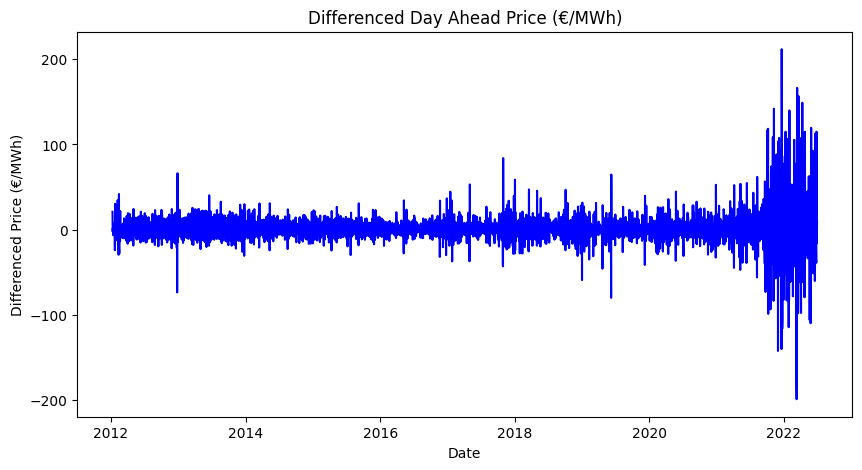

ADF Statistic: -15.429463005454169
p-value: 2.961677446374705e-28
KPSS Statistic: 0.41163254453847936
p-value: 0.07214114459548304


In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

df_diff = train_df.copy()

# Perform first-order differencing on the target variable
df_diff['Day_ahead_price_diff'] = df_diff['Day_ahead_price (€/MWh)'].diff(
).dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df_diff['Date'], df_diff['Day_ahead_price_diff'], color='blue')
plt.title('Differenced Day Ahead Price (€/MWh)')
plt.xlabel('Date')
plt.ylabel('Differenced Price (€/MWh)')
plt.show()

# Perform ADF test on differenced data
adf_result = adfuller(df_diff['Day_ahead_price_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Perform KPSS test on differenced data
kpss_stat, p_value, lags, crit_values = kpss(
    df_diff['Day_ahead_price_diff'].dropna())
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)

## Autoarima

In [ ]:
# Entire prediction length for test data

import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go

# Global variables
TARGET_COLUMN = "Day_ahead_price (€/MWh)"
START_DATE = "2022-07-01"
END_DATE = "2024-07-28"
INCLUDE_LAGS = False


def load_and_prepare_data(file_path, include_lags):
    """
    Load and prepare the dataset with or without lags.

    Args:
        file_path (str): Path to the CSV file.
        include_lags (bool): If True, includes lagged covariates.

    Returns:
        tuple: Time series data and covariates DataFrames.
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    covariate_columns = future_covariates_with_lags if include_lags else future_covariates_no_lags
    y = df.set_index('Date')[TARGET_COLUMN]
    X = df[['Date'] + covariate_columns].set_index('Date')
    return y.squeeze(), X


def fit_best_sarima_model(y_train, X_train):
    """
    Fit the best SARIMA model using auto_arima on the training data with covariates.

    Args:
        y_train (pd.Series): Target training data.
        X_train (pd.DataFrame): Covariate training data.

    Returns:
        pmdarima.ARIMA: The fitted SARIMA model.
    """
    best_model = auto_arima(
        y=y_train,
        X=X_train,
        start_p=0,
        start_q=0,
        start_P=0,
        start_Q=0,
        m=7,
        seasonal=True,
        stepwise=True,
        information_criterion='bic'
    )
    print(best_model.summary())
    return best_model


def generate_forecasts(best_model, X_forecast):
    """
    Generate multi-step forecasts using the best SARIMA model with covariates.

    Args:
        best_model (pmdarima.ARIMA): The fitted SARIMA model.
        X_forecast (pd.DataFrame): Future covariates for forecast period.

    Returns:
        pd.DataFrame: DataFrame containing dates and forecasted prices.
    """
    n_periods = len(X_forecast)
    forecast = best_model.predict(n_periods=n_periods, X=X_forecast)
    return pd.DataFrame({'Date': X_forecast.index, 'Forecasted_price': forecast})


def calculate_metrics(y_true, y_pred):
    """
    Calculate and print error metrics for the forecasts.

    Args:
        y_true (np.ndarray): Actual values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        pd.DataFrame: DataFrame with error metrics.
    """
    mape_value = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = mean_squared_error(y_true, y_pred, squared=False)
    mse_value = mean_squared_error(y_true, y_pred)
    smape_value = np.mean(np.abs(y_true - y_pred) /
                          ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

    print("Error Metrics on Test Set:")
    print(f"MAPE: {mape_value:.2f}%")
    print(f"MAE: {mae_value:.2f}")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MSE: {mse_value:.2f}")
    print(f"SMAPE: {smape_value:.2f}%")

    metrics_df = pd.DataFrame({
        "Metric": ["MAPE", "MAE", "RMSE", "MSE", "SMAPE"],
        "Value": [mape_value, mae_value, rmse_value, mse_value, smape_value]
    })
    return metrics_df


def plot_forecasts(y_true, forecast_df, estimated_std_dev):
    """
    Plot actual vs forecasted values with confidence intervals.

    Args:
        y_true (pd.Series): Actual values.
        forecast_df (pd.DataFrame): DataFrame containing dates and forecasted values.
        estimated_std_dev (float): Estimated standard deviation of residuals.
    """
    fig = go.Figure()

    # Actual data trace
    fig.add_trace(go.Scatter(
        x=y_true.index, y=y_true.values,
        mode='lines', line=dict(color="#3f4751", width=1),
        name="Actual"
    ))

    # Forecast mean trace
    fig.add_trace(go.Scatter(
        x=forecast_df["Date"], y=forecast_df["Forecasted_price"],
        mode='lines', line=dict(color="#ca8a04", width=1),
        name="Forecast"
    ))

    # Forecast +/- 1 standard deviation band
    fig.add_trace(go.Scatter(
        x=forecast_df["Date"], y=forecast_df["Forecasted_price"] +
        estimated_std_dev,
        fill=None, mode='lines', line=dict(color="#ca8a04", width=0.5), showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=forecast_df["Date"], y=forecast_df["Forecasted_price"] -
        estimated_std_dev,
        fill='tonexty', mode='lines', line=dict(color="#ca8a04", width=0.5),
        name="Forecast +/- 1 Std. Dev.", opacity=0.2
    ))

    # Layout
    fig.update_layout(
        title=f"SARIMA Forecast for {TARGET_COLUMN} {'with' if INCLUDE_LAGS else 'without'} Lags",
        xaxis_title="Time", yaxis_title="Value",
        legend=dict(x=1.05, y=1),
        margin=dict(l=50, r=50, t=50, b=50),
        template="plotly_white",
        width=1500, height=450
    )

    fig.show()


def save_results(metrics_df, forecast_df, include_lags):
    """
    Save error metrics and forecasted values to CSV files.

    Args:
        metrics_df (pd.DataFrame): DataFrame with error metrics.
        forecast_df (pd.DataFrame): DataFrame with forecasted values.
        include_lags (bool): Flag indicating if lags were included in the model.
    """
    metrics_path = f"sarima_error_metrics_{'with' if include_lags else 'without'}_lags.csv"
    forecast_path = f"forecasted_values_sarima_{'with' if include_lags else 'without'}_lags.csv"

    metrics_df.to_csv(metrics_path, index=False)
    forecast_df.to_csv(forecast_path, index=False)

    print(f"Error metrics saved at: {metrics_path}")
    print(f"Forecasted values saved at: {forecast_path}")


def main():
    # Determine file path based on include_lags flag
    file_path = '../../data/Final_data/final_data_july.csv' if INCLUDE_LAGS else '../../data/Final_data/final_data_no_lags.csv'

    # Load and prepare data
    y, X = load_and_prepare_data(file_path, INCLUDE_LAGS)

    # Split the data into training and forecasting periods
    y_train = y[y.index < START_DATE]
    X_train = X[X.index < START_DATE]
    X_forecast = X[(X.index >= START_DATE) & (X.index <= END_DATE)]

    # Fit SARIMA model with covariates
    best_sarima_model = fit_best_sarima_model(y_train, X_train)

    # Generate forecasts with covariates
    forecast_df = generate_forecasts(best_sarima_model, X_forecast)

    # Calculate error metrics
    result_df = pd.DataFrame(
        {'Date': y[y.index >= START_DATE].index, 'Actual': y[y.index >= START_DATE].values})
    result_df = result_df.merge(forecast_df, on='Date')
    metrics_df = calculate_metrics(
        result_df['Actual'], result_df['Forecasted_price'])

    # Estimate standard deviation of residuals on training data
    train_predictions = best_sarima_model.predict_in_sample(X=X_train)
    residuals = y_train - train_predictions
    estimated_std_dev = np.std(residuals)

    # Plot forecasts with confidence intervals
    plot_forecasts(result_df.set_index('Date')[
                   'Actual'], forecast_df, estimated_std_dev)

    # Save results
    save_results(metrics_df, forecast_df, INCLUDE_LAGS)


if __name__ == "__main__":
    main()

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3827
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood              -14626.761
Date:                                Tue, 05 Nov 2024   AIC                          29313.521
Time:                                        14:56:22   BIC                          29501.009
Sample:                                    01-08-2012   HQIC                         29380.131
                                         - 06-30-2022                                         
Covariance Type:                                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Solar_radiation (W/m2)             -0.00

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Error metrics saved at: sarima_error_metrics_without_lags.csv
Forecasted values saved at: forecasted_values_sarima_without_lags.csv


# Crossvalidation

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

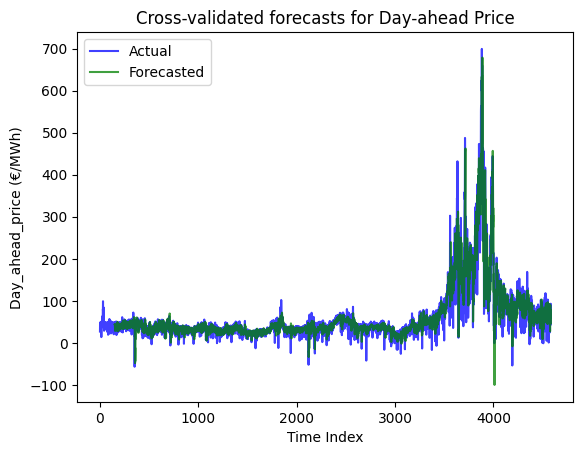

In [ ]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import model_selection
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Parameters (adjust as needed)
TARGET_COLUMN = "Day_ahead_price (€/MWh)"
WINDOW_SIZE = 150  # Number of training samples in each window
STEP_SIZE = 4  # Step size for each iteration in cross-validation
HORIZON = 4  # Forecast horizon (number of steps ahead to predict)

# Load custom data
file_path = '../../data/Final_data/final_data_july.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
y = df.set_index('Date')[TARGET_COLUMN].squeeze()

# Initialize the ARIMA model with  preferred parameters
est = pm.ARIMA(order=(5, 1, 1), seasonal_order=(
    2, 0, 0, 7), suppress_warnings=True)

# Define a cross-validation strategy with a sliding window approach
cv = model_selection.SlidingWindowForecastCV(
    window_size=WINDOW_SIZE, step=STEP_SIZE, h=HORIZON)

# Perform cross-validation and get predictions
predictions = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

# Generate an x-axis for plotting
x_axis = np.arange(y.shape[0])
n_test = predictions.shape[0]

# Plot the original series and the cross-validated predictions
plt.plot(x_axis, y, alpha=0.75, c='b', label="Actual")
plt.plot(x_axis[-n_test:], predictions, alpha=0.75,
         c='g', label="Forecasted")  # Forecasts
plt.title("Cross-validated forecasts for Day-ahead Price")
plt.xlabel("Time Index")
plt.ylabel("Day_ahead_price (€/MWh)")
plt.legend()
plt.show()